# PS 88 - Lab 12 - DiD and Fixed Effects

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Propaganda News

Let's explore a simulated example of media persuasion with more than two time periods and more than two people. 

Suppose the president of a semi-democratic country tries to increase his control by introducing the Propaganda News Channel (PNC). The president was gradually increasing his popularity over time, and PNC was introduced 5 years into his term. Suppose the owners also generally targeted regions with more people who support the president to get higher viewership. 

As we will see, this creates multiple sources of selection bias in trying to estimate the causal effect of PNC, but the one-two punch of two-way fixed effects will knock all of them out.

We will study some hypothetical survey data, collected over 10 years (2000-2009). Each respondent lives in one of four regions, which we label 1-4. Citizens in "higher" regions tend to like the president more. Our key outcome variable will be the approval rating of the president, which ranges from 0 to 100.

PNC is available in regions 3 and 4 starting in 2006.

The simulation generates the potential outcomes of approval without access to PNC, and then adds the true causal effect (a 5 point approval boost) to those where PNC is available. 

In [2]:
# True causal effect
k=5
yr = np.random.randint(2000,2010, 100000)
region = np.random.randint(1,5, size=100000)
approve0 = 60*np.random.rand(100000) + 2*np.sqrt(yr - 2000) +2*region**2
avail = 1*(region > 2)*(yr > 2005)
approve = np.where(avail==1, approve0 + k, approve0)
pncdata = pd.DataFrame({"Year":yr, "Region": region, "Available":avail, "Approve":approve})
#pncdata = pd.DataFrame({"Year":yr, "Region": region, "Available":avail, "Watch":watch, "Approve":approve})
pncdata

,Year,Region,Available,Approve
0,2008,4,1,46.421133
1,2009,4,1,54.566173
2,2007,2,0,58.500744
3,2002,3,0,39.931107
4,2001,4,0,85.222624
...,...,...,...,...
99995,2004,3,0,74.119637
99996,2008,1,0,45.434407
99997,2003,3,0,69.433336
99998,2007,4,1,86.621959


To check the simulation did what we want and get some practice with exploring the data, let's look at a crosstab (like a pivot table) that counts how many respondents there are by `Year` and `Available`. We can do this with `pd.crosstab`, where we input as arguments two columns, and the output is a count of how many cases take on each combination of values of the two columns:

In [3]:
pd.crosstab(pncdata['Year'],pncdata['Available'])

Available,0,1
Year,,
2000,9937,0
2001,10040,0
2002,10102,0
2003,9944,0
2004,9905,0
2005,10010,0
2006,5083,5051
2007,4946,4904
2008,5024,5004


**Question 1.1 Create a crosstab that counts how many had respondents had PNC available by region**

We can plot the overall approval over time with `sns.lineplot`.

<AxesSubplot:xlabel='Year', ylabel='Approve'>

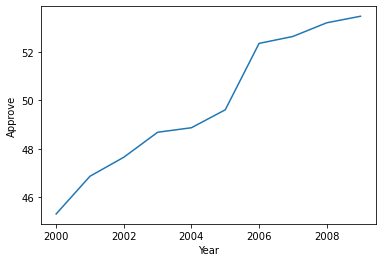

In [4]:
sns.lineplot(x='Year', y='Approve', data=pncdata, ci=None)

Clearly this is trending up. Since the station was rolled out later in the time window, this might create confounding as those who have access to PNC will be in the later years.

We can also compute the average approval by region using the `groupby` function`. 

In [5]:
pncdata.groupby("Region")['Approve'].mean()

Region
1    36.020373
2    41.918392
3    53.811102
4    67.923850
Name: Approve, dtype: float64

There are big differences here, with approval much higher in the regions that got PNC (3 and 4). But this might be because the president is just more popular there in general.

What is the average approval for people with access to PNC vs. not? To facilitate later comparisons, let's use `smf.ols` to run a linear regression to answer this.

In [6]:
smf.ols('Approve ~ Available', data=pncdata).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Approve   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                 1.498e+04
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:04:01   Log-Likelihood:            -4.4113e+05
No. Observations:              100000   AIC:                         8.823e+05
Df Residuals:                   99998   BIC:                         8.823e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.0242      0.070    653.418      0.000      45.886      46.162
Available     19.3146      0.158    122.396      0.000      19.005      19.624
==============================================================================
Omnibus:                     5666.054   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2222.769
Skew:                           0.086   Prob(JB):                         0.00
Kurtosis:                       2.290   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The available coefficient tells us that approval of the president is much higher among those with access to PNC, and this difference is much bigger than the real causal effect of 5.

Now let's add some "region fixed effects". An easy way to do this with `smf.ols` is to first create a "string" version of the region using the `.astype` function. When we include the string version of region as an independent variable, `smf.ols` automatically produces dummy variables for each region.

In [7]:
pncdata['Region_s'] = pncdata['Region'].astype(str)
smf.ols('Approve ~ Available + Region_s', data=pncdata).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Approve   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.292e+04
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:04:03   Log-Likelihood:            -4.2727e+05
No. Observations:              100000   AIC:                         8.546e+05
Df Residuals:                   99995   BIC:                         8.546e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        36.0204      0.110    328.854      0.000      35.806      36.235
Region_s[T.2]     5.8980      0.155     38.058      0.000       5.594       6.202
Region_s[T.3]    14.7620      0.168     88.054      0.000      14.433      15.091
Region_s[T.4]    28.9037      0.168    172.418      0.000      28.575      29.232
Available         7.5414      0.159     47.524      0.000       7.230       7.852
==============================================================================
Omnibus:                    71881.164   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5764.635
Skew:                          -0.008   Prob(JB):                         0.00
Kurtosis:                       1.824   Cond. No.                         5.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The output is a bit goofy, but we can see that it is creating dummy variabels for regions 2, 3, and 4 (not sure what the T is about here). Since region 1 doesn't have a dummy variable, it is the *referent category*. The coefficient on `Region_s[T.2]` tells us how much higher the approval is in region 2 vs region 1, on average, keeping fixed all other variables. The coefficients on the other regions are how much higher (or lower) the approval is compared to the referent category of region 1. 

Note the coefficient on `Available` goes down when we add the region fixed effects. This means that a lot of the difference in average approval among those with access to PNC vs not was driven by the fact that it was only available in regions that already liked the president.

**Question 1.2. Create a string version of `Year`, and run a regression predicting Approval with `Available`, the year fixed effects, and the region fixed effects. Does this produce an estimate close to the real casual effect of 5?**

*Words for 1.2*

Note: what follows is optional.

This method can also work even if there isn't just a single time period where one group gets the treatment. Here is some alternative simulated data where PNC is "rolled out" by region, first going to region 4, then 3, then 2, then 1. 

In [8]:
avail2 = 1*(region + yr > 2006)
approve2 = np.where(avail2==1, approve0 + k, approve0)
pncdata2 = pd.DataFrame({"Year":yr, "Region": region, "Available":avail2, "Approve":approve2})
#pncdata = pd.DataFrame({"Year":yr, "Region": region, "Available":avail, "Watch":watch, "Approve":approve})
pncdata2

,Year,Region,Available,Approve
0,2008,4,1,46.421133
1,2009,4,1,54.566173
2,2007,2,1,63.500744
3,2002,3,0,39.931107
4,2001,4,0,85.222624
...,...,...,...,...
99995,2004,3,1,79.119637
99996,2008,1,1,50.434407
99997,2003,3,0,69.433336
99998,2007,4,1,86.621959


The following crosstab shows the steady increase in access to PNC starting in 2003.

In [9]:
pd.crosstab(pncdata2['Year'], pncdata2['Available'])

Available,0,1
Year,,
2000,9937,0
2001,10040,0
2002,10102,0
2003,7407,2537
2004,5006,4899
2005,2548,7462
2006,0,10134
2007,0,9850
2008,0,10028


**Question  1.3 [Optional]. Show that a regression with year and region fixed effects can still identify the causal effect of availability on approval in this data set.**

## Part 2: Bringing it back full circle

Let's revisit an example from week 1: did the expiration of the Federal Assault Weapon ban lead to more homicides in areas of Mexico which are close to states in the US where the expiration made guns more accessible? In week 1 we just replicated a graph, now let's dig into the full replication data file from the <a href="https://piazza.com/class_profile/get_resource/kshlibk6iwsbj/kskovf9u5ma150">paper</a> by Dube, Dube, and Garcia-Ponce.

The analysis we will do is related to Table 2 in their paper, though they use a somewhat different regression method (the results are similar).

In [10]:
ddg = pd.read_stata("cross_border_main.dta")
ddg

,statename,munname,muncode,year,pop,NCAseg18,negdistNCA18,negdist18,mindistNCA18,mindist18,...,nppm0204p,lexptotalpc,ltot4drugs_value_mexp1,lmarijuana_hectaresp1,lpoppy_hectaresp1,ltotal_4drugs_value18,ldeportable18,lport_ave_earn18,port_emp_rat18,homds_sum
0,Baja California,Mexicali,2002.0,2002-01-01,793103.0,0.0,0.915787,0.935095,0.084213,0.064905,...,1.0,-6.579107,18.980207,0.574082,0.000000,19.488834,11.592411,10.222232,0.352164,516.0
1,Baja California,Mexicali,2002.0,2003-01-01,814899.0,0.0,0.915787,0.935095,0.084213,0.064905,...,1.0,-6.399465,18.352587,5.392031,3.281851,19.432281,11.430619,10.249273,0.356448,516.0
2,Baja California,Mexicali,2002.0,2004-01-01,835867.0,0.0,0.915787,0.935095,0.084213,0.064905,...,1.0,-6.281058,18.576866,2.872377,2.668061,19.468000,11.218111,10.272012,0.350987,516.0
3,Baja California,Mexicali,2002.0,2005-01-01,854879.0,0.0,0.915787,0.935095,0.084213,0.064905,...,1.0,-6.250871,19.014620,0.000000,0.000000,19.957548,10.928202,10.308653,0.353121,516.0
4,Baja California,Mexicali,2002.0,2006-01-01,873937.0,0.0,0.915787,0.935095,0.084213,0.064905,...,1.0,-6.086829,18.065960,0.000000,0.000000,20.603355,11.026288,10.310818,0.360647,516.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,Tamaulipas,Valle Hermoso,28040.0,2002-01-01,60973.0,0.0,0.975491,0.975491,0.024509,0.024509,...,0.0,-6.884375,0.000000,0.000000,0.000000,17.921453,11.406754,10.038018,0.328034,19.0
531,Tamaulipas,Valle Hermoso,28040.0,2003-01-01,61583.0,0.0,0.975491,0.975491,0.024509,0.024509,...,0.0,-6.807280,0.000000,0.000000,0.000000,17.865555,11.261241,10.066584,0.320439,19.0
532,Tamaulipas,Valle Hermoso,28040.0,2004-01-01,62153.0,0.0,0.975491,0.975491,0.024509,0.024509,...,0.0,-6.687960,0.000000,0.000000,0.000000,18.394337,11.439785,10.094893,0.318011,19.0
533,Tamaulipas,Valle Hermoso,28040.0,2005-01-01,62769.0,0.0,0.975491,0.975491,0.024509,0.024509,...,0.0,-6.623382,0.000000,0.000000,0.000000,18.690708,11.806997,10.121900,0.313354,19.0


Each row is corresponds to a year in a city (Municipio), for 2002-2006. The main dependent variables are the number of homicides (`homicides`) and gun-related homicides (`homdguns`) in that city-year. The "treatment" here is being in a city not bordering CA after 2004. 

First, we follow the paper in restricting analysis to cities close to the border.

In [11]:
ddg = ddg[ddg['border']==1]

We'll want the year in string format to run regressions later. Doing this involves fiddling with the date format (an annoying process in every statistical software I have worked with). You can skip over the detials here, but in the end we get a nice string corresponding to the year as `year_s`. 

In [13]:
ddg['year_n'] = pd.DatetimeIndex(ddg['year']).year
ddg['year_s'] = ddg['year_n'].astype('str')

/tmp/ipykernel_57/2275492025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddg['year_n'] = pd.DatetimeIndex(ddg['year']).year
/tmp/ipykernel_57/2275492025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddg['year_s'] = ddg['year_n'].astype('str')


I'd like to give our main variables some more intuitive names. We are goign to rename the variable indicating the city is close to a non-CA state as `non_ca`, and the indicator for being in one of these cities after 2004 as `Expire`. We can do this with the `rename` function (we'll talk about this more next week).

In [14]:
ddg.rename(columns={"NCAseg18xpost":"Expire", "NCAseg18":"non_ca"}, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Let's do a crosstab of the year and whether the ban expired:

In [15]:
pd.crosstab(ddg['year_s'], ddg['Expire'])

Expire,0.0,1.0
year_s,,
2002,38,0
2003,38,0
2004,38,0
2005,3,35
2006,3,35


One notable thing here is that we don't have a lot of cities close to CA: we can see this because there are just 3 observations in 2005 and 2006 where the ban didn't expire.

**Question 2.1. Use `smf.ols` to run a regression with the count of homicides (`homicide`) and as the dependent variable and `Expire` as the independent variable. Why might this not be a good estimate of the effect of the expiration of the ban?**

*Words for 2.1*

Now let's do a regression that compares how the average homicides in the non-CA vs CA changed after the expiration. Recall the following regression effectively does a "difference in difference of means", where the coefficint on `Expire` tells us how much the difference in means between the non-CA municipios and the CA municipios changes after the AWB expired.

In [37]:
smf.ols('homicide ~ Expire + post + non_ca', data=ddg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               homicide   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     23.62
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           5.32e-13
Time:                        10:44:03   Log-Likelihood:                -1015.7
No. Observations:                 190   AIC:                             2039.
Df Residuals:                     186   BIC:                             2052.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    133.8889     17.097      7.831      0.000     100.160     167.617
Expire         8.5746     28.167      0.304      0.761     -46.993      64.143
post          -4.3889     27.032     -0.162      0.871     -57.718      48.941
non_ca      -119.3460     17.814     -6.699      0.000    -154.490     -84.202
==============================================================================
Omnibus:                      123.123   Durbin-Watson:                   0.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              809.472
Skew:                           2.499   Prob(JB):                    1.68e-176
Kurtosis:                      11.790   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We get a positive coefficient on Expire, which indicates there are 8 more homicides per municipio per year. While we didn't cover it here, at this point you should have covered standard erros in Data 8, and these ones are much bigger than the coefficient, which means we are pretty uncertain about the real effect of the ban expiring. Intuitively, since there aren't a lot of cities in the post 2004/close to CA category, it is hard to pin down precisely the effect of the ban.

This is one area where fixed effects can help us. By adjusting for the fact that some cities are more violent than others, we can get a more precise estimate. 

**Question 2.2. Use `smf.ols` to run a regression with the number of homicides as the dependent variable, and `Expire` and city fixed effects as dependent variables. (Hint: the `munname` variable is a string corresponding to each city, so we don't need to create a new to add fixed effects.)**

You should get a smaller coefficient on `Expire` than the previous regression, but the standard error is also far smaller, so we can be more confident that it is positive. 

**Question 2.3. Now run the previous regression but with year fixed effects added (recall `year_s` is a string version of the year)**

.. Which leads to a bigger coefficient, but also a somewhat bigger standard error.

**Question 2.4 [Optional]. Repeat this analysis with gun-related homicides (`homdguns`) as the dependent variable.**